###  Libraries

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans, GlobalKernelKMeansPP 
from Rings import Rings
from Common_Modules.Evaluation import Evaluator
from Common_Modules.Graph import Graph

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Global Variables

In [2]:
seed = 42
evaluator = Evaluator()
graph_is_enabled = True
kMeans_is_enabled = False
kernelKMeans_is_enabled = False
kernelKMeansPP_is_enabled = True
globalKernelKMeans_is_enabled = True
globalKernelKMeansPP_is_enabled = True

### Load Dataset

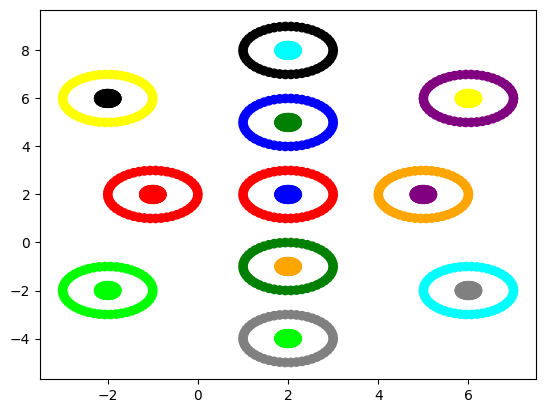

In [3]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']
centers_coordinates = [(-1, 2), (2, 2), (2, 5), (2, -1), (5, 2), (6, 6), (-2, 6), (2, 8), (6, -2), (2, -4), (-2, -2)]

rings = Rings(colors)
X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=100, factor=0.2, noise=0.0)

K = 2 * len(centers_coordinates)
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)

### Create Graph

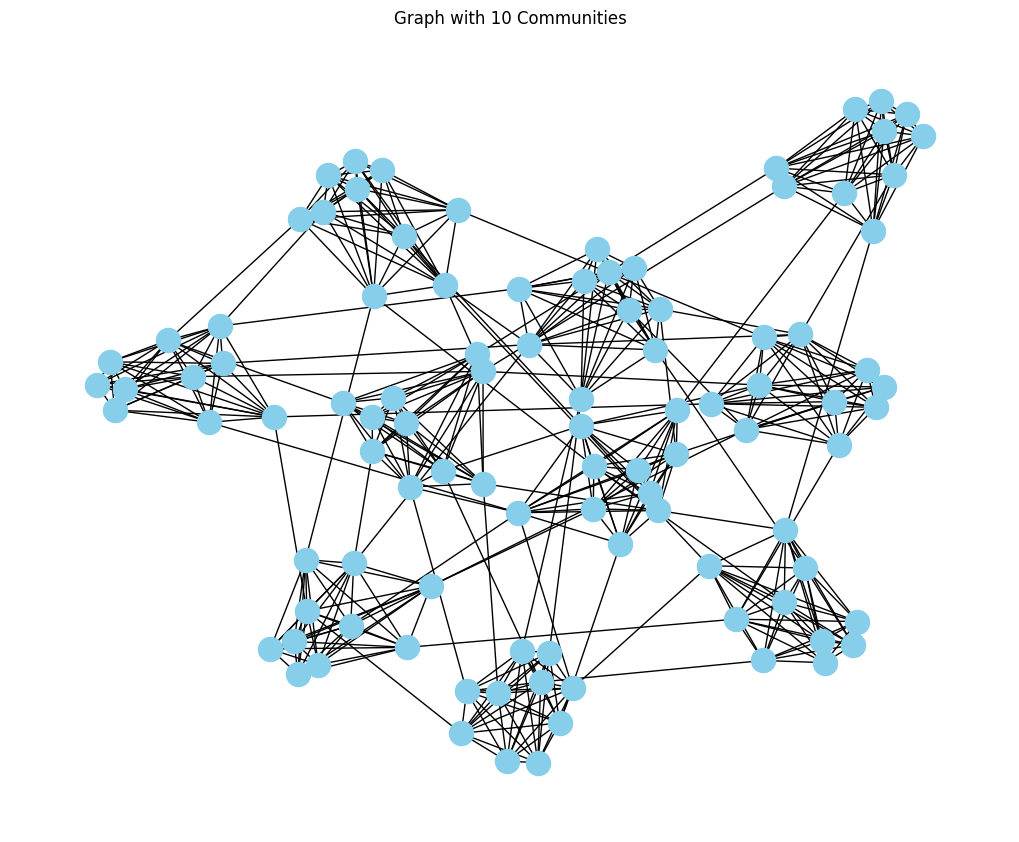

In [4]:
if(graph_is_enabled):
    # Number of nodes per community
    n_nodes_per_community = 10

    # Number of communities
    K = n_communities = 10
    
    # Probability of intra-community edge
    p_intra = 1  
    
    # Probability of inter-community edge
    p_inter = 0.01  

    graph = Graph(n_communities, n_nodes_per_community, p_intra, p_inter, colors)
    graph.create_adj_matrix()
    kernel_matrix = graph.adj_matrix = pairwise_kernels(graph.adj_matrix, graph.adj_matrix, metric='rbf', gamma=0.1)
    graph.create_kernel_matrix_from_adj_matrix()

### kMeans

In [5]:
if(kMeans_is_enabled):
    kmeans = KMeans(n_clusters=K).fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
    evaluator.print_evaluation()
    rings.plot(X, kmeans.labels_)

### Kernel kMeans

In [6]:
if(kernelKMeans_is_enabled):
    kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
    evaluator.print_evaluation()
    rings.plot(X, kernel_kmeans.labels_)

### Kernel kMeans++

Execution 0 of Kernel k-Means with k-means++ initialization
Finished in Iter: 2 MSE: 34.6723
Execution 1 of Kernel k-Means with k-means++ initialization
Finished in Iter: 2 MSE: 34.5479
Execution 2 of Kernel k-Means with k-means++ initialization
Finished in Iter: 2 MSE: 40.1105
Execution 3 of Kernel k-Means with k-means++ initialization
Finished in Iter: 2 MSE: 39.2575
Execution 4 of Kernel k-Means with k-means++ initialization
Finished in Iter: 2 MSE: 34.2999
Execution 5 of Kernel k-Means with k-means++ initialization
Finished in Iter: 2 MSE: 33.9505
Execution 6 of Kernel k-Means with k-means++ initialization
Finished in Iter: 2 MSE: 39.7567
Execution 7 of Kernel k-Means with k-means++ initialization
Finished in Iter: 2 MSE: 39.6146
Execution 8 of Kernel k-Means with k-means++ initialization
Finished in Iter: 2 MSE: 44.2108
Execution 9 of Kernel k-Means with k-means++ initialization
Finished in Iter: 2 MSE: 34.0759


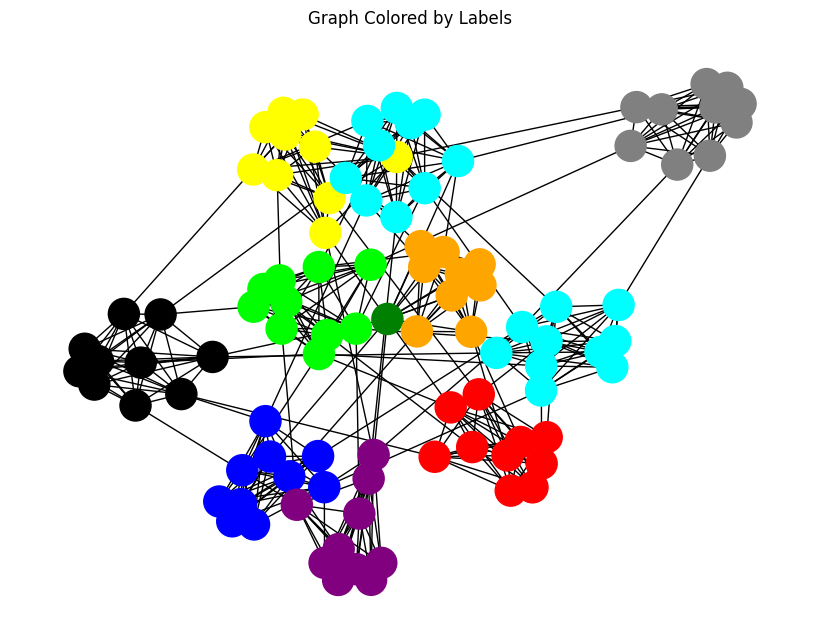

In [7]:
if(kernelKMeansPP_is_enabled):
    kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=10, init='k-means++', verbose=1)
    kernelKMeans.fit()
    
    if graph_is_enabled:
        graph.plot_clusters(kernelKMeans.labels_)
    else:
        acc, pur, nmi, ari = evaluator.evaluate_model(y, kernelKMeans.labels_)
        evaluator.print_evaluation()
        rings.plot(X, kernelKMeans.labels_)

        # That's the function of grount truth error
        ground_truth_error = kernelKMeans.calculate_ground_truth_error(y)
        print(f"Ground Truth Error is: {ground_truth_error}")

### Global Kernel kMeans

Solving Kernel 2-means
Solved 2-means MSE: 73.9578075367925
Solving Kernel 3-means
Solved 3-means MSE: 68.21198690627638
Solving Kernel 4-means
Solved 4-means MSE: 62.47545498555608
Solving Kernel 5-means
Solved 5-means MSE: 56.751796260068346
Solving Kernel 6-means
Solved 6-means MSE: 51.038699204570804
Solving Kernel 7-means
Solved 7-means MSE: 45.45475654773424
Solving Kernel 8-means
Solved 8-means MSE: 39.89605741831407
Solving Kernel 9-means
Solved 9-means MSE: 34.41101992463292
Solving Kernel 10-means
Solved 10-means MSE: 29.08436097433182


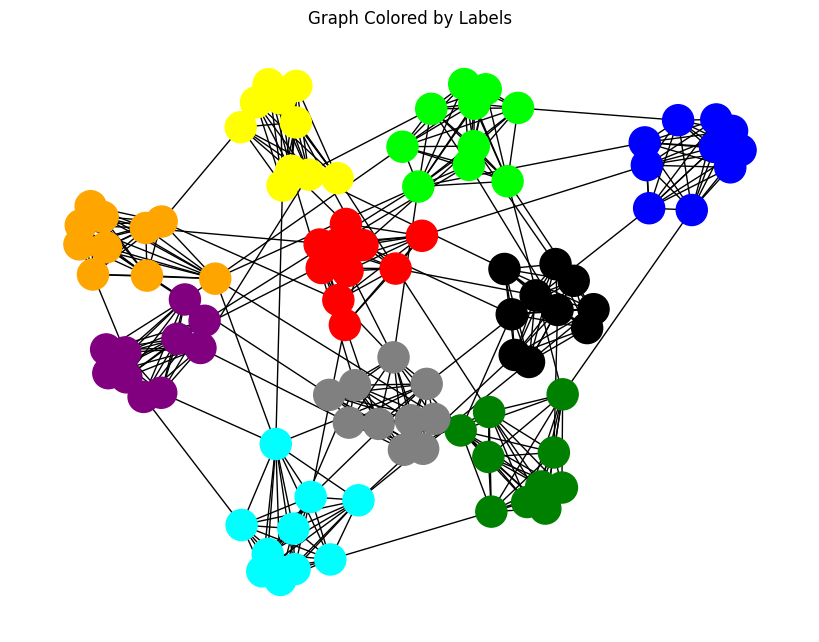

In [8]:
if(globalKernelKMeans_is_enabled):
    globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, verbose=1)
    globalKernelKMeans.fit()

    if graph_is_enabled:
        graph.plot_clusters(globalKernelKMeans.labels_[K])
    else:
        acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeans.labels_[K])
        evaluator.print_evaluation()
        rings.plot(X, globalKernelKMeans.labels_[K])

### Global Kernel kMeans++

Solving 2-means
Solved 2-means MSE: 74.33640635493896
Solving 3-means
Solved 3-means MSE: 68.59133342502264
Solving 4-means
Solved 4-means MSE: 62.4902574527989
Solving 5-means
Solved 5-means MSE: 56.75047959581333
Solving 6-means
Solved 6-means MSE: 51.038699204570804
Solving 7-means
Solved 7-means MSE: 45.45475654773424
Solving 8-means
Solved 8-means MSE: 39.89605741831407
Solving 9-means
Solved 9-means MSE: 34.41101992463292
Solving 10-means
Solved 10-means MSE: 29.08436097433182


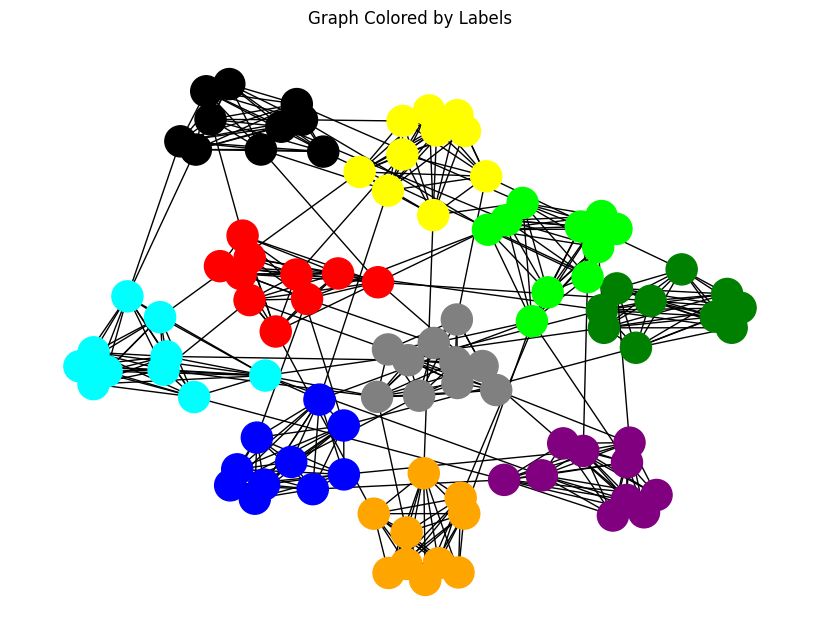

In [9]:
if(globalKernelKMeansPP_is_enabled):
    globalKernelKMeansPP = GlobalKernelKMeansPP(n_clusters=K, kernel_matrix=kernel_matrix, n_candidates=10, sampling='sequential', verbose=1)
    globalKernelKMeansPP.fit()
    
    if graph_is_enabled:
        graph.plot_clusters(globalKernelKMeansPP.labels_[K])
    else:
        acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeansPP.labels_[K])
        evaluator.print_evaluation()
        rings.plot(X, globalKernelKMeansPP.labels_[K])